2025-03-21 20:34:17,042 [INFO] - Using device: cuda
2025-03-21 20:34:17,042 [INFO] - GPU: NVIDIA GeForce RTX 3060 Laptop GPU
2025-03-21 20:34:17,042 [INFO] - GPU Memory: 6.00 GB
2025-03-21 20:34:17,042 [INFO] - CUDA Version: 12.4
2025-03-21 20:34:17,042 [INFO] - cuDNN benchmark mode enabled
2025-03-21 20:34:17,053 [INFO] - CPU: 16 cores available
2025-03-21 20:34:17,057 [INFO] - GPU: NVIDIA GeForce RTX 3060 Laptop GPU with 6.00GB memory
2025-03-21 20:34:17,057 [INFO] - RTX 3060 detected - using optimized settings
2025-03-21 20:34:17,057 [INFO] - Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
2025-03-21 20:34:17,057 [INFO] - PyTorch version: 2.5.1
2025-03-21 20:34:17,057 [INFO] - Torchvision version: 0.20.1
2025-03-21 20:34:17,057 [INFO] - Configuration: {
    "seed": 42,
    "model_name": "resnet50_teacher",
    "dataset": "CIFAR-10",
    "use_amp": true,
    "memory_efficient_attention": false,
    "prefetch_factor": 2,
   

Files already downloaded and verified
Files already downloaded and verified


2025-03-21 20:34:19,059 [INFO] - Training samples: 45000
2025-03-21 20:34:19,059 [INFO] - Validation samples: 5000
2025-03-21 20:34:19,061 [INFO] - Test samples: 10000
2025-03-21 20:34:19,061 [INFO] - Loading pretrained ResNet50 model...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Gading/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 12.8MB/s]
2025-03-21 20:34:27,857 [INFO] - Model created: ResNet50 adapted for CIFAR-10 with 10 classes
2025-03-21 20:34:28,005 [INFO] - Configuration saved to C:\Users\Gading\Downloads\Research\Results\ResNet50\resnet50_teacher_20250321_203428_config.json
2025-03-21 20:34:28,005 [INFO] - Batch size: 128 with gradient accumulation steps: 1
2025-03-21 20:34:28,011 [INFO] - Effective batch size: 128
2025-03-21 20:34:28,011 [INFO] - GPU Memory: Current=89.99MB, Peak=89.99MB, Reserved=118.00MB
2025-03-21 20:34:28,011 [INFO] - Starting training...
2025-03-21 20:34:28,011 [IN

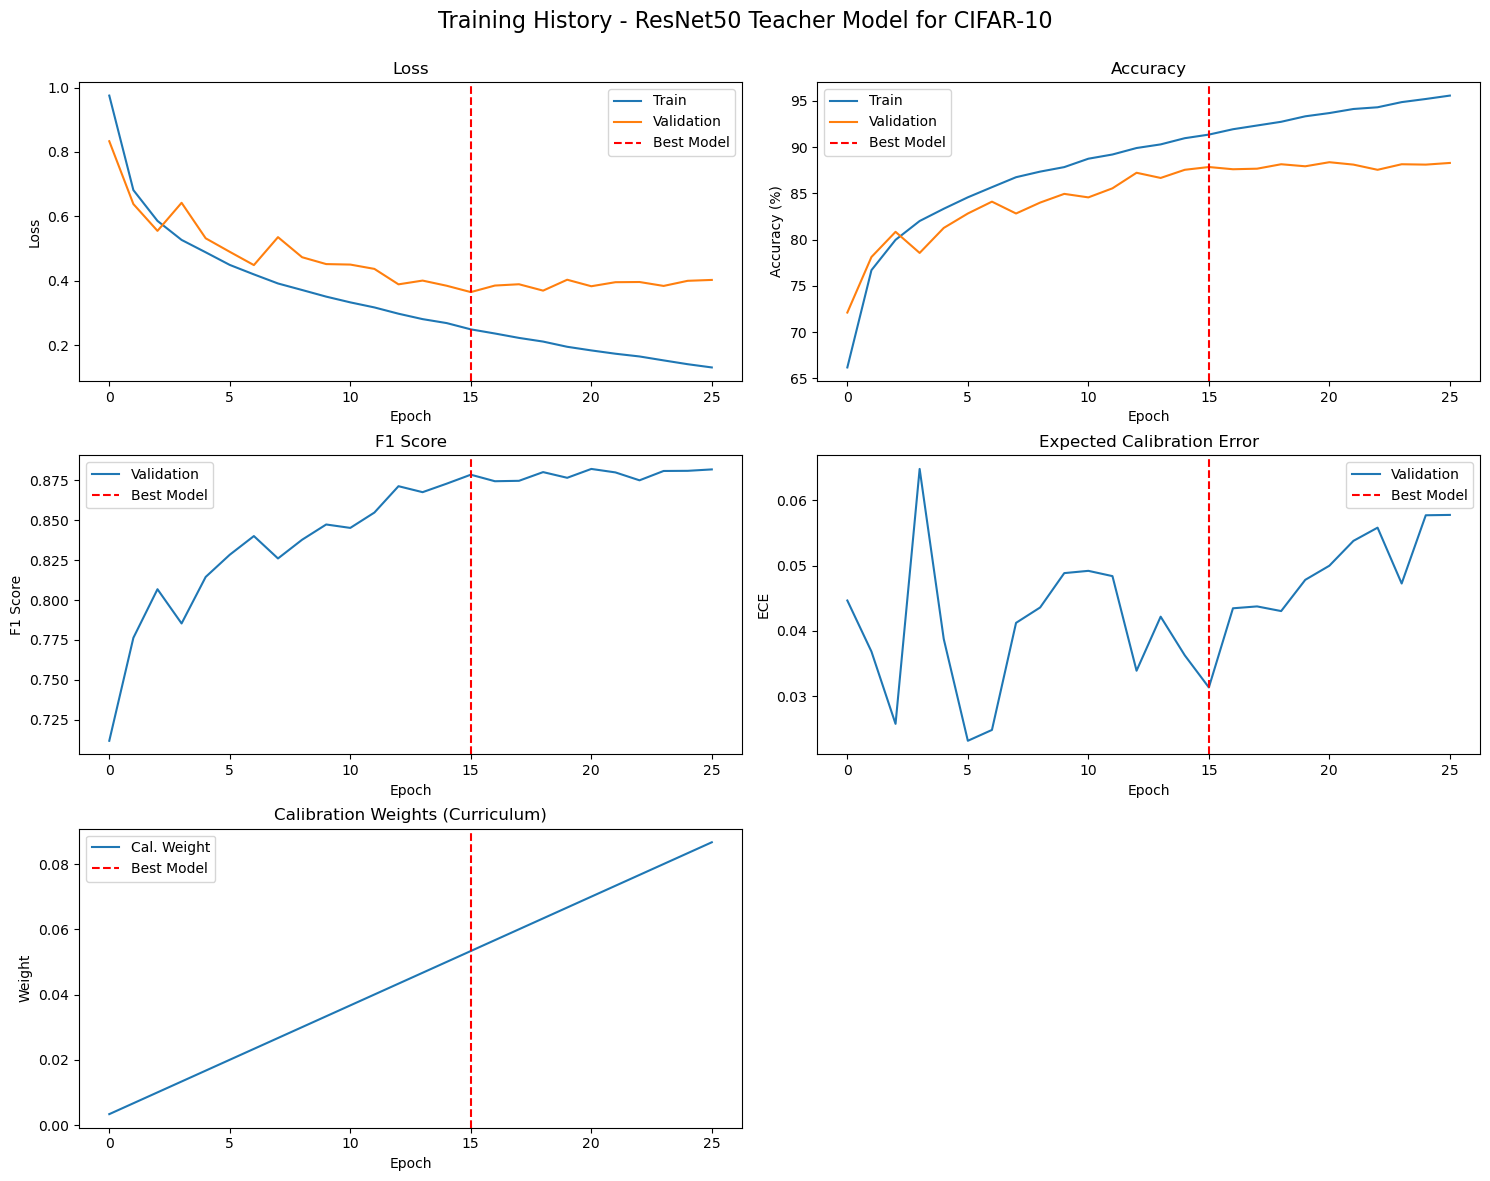

2025-03-22 14:41:27,020 [INFO] - GPU cache cleared: 201.87MB → 201.87MB (freed 0.00MB)
2025-03-22 14:41:27,020 [INFO] - Using zero padding with pad_size=96 pixels on each side


Files already downloaded and verified
Files already downloaded and verified


2025-03-22 14:41:28,628 [INFO] - Training samples: 45000
2025-03-22 14:41:28,628 [INFO] - Validation samples: 5000
2025-03-22 14:41:28,628 [INFO] - Test samples: 10000
Computing calibration data: 100%|██████████| 79/79 [00:26<00:00,  2.93it/s]
2025-03-22 14:41:56,032 [INFO] - Calibration curve saved to C:\Users\Gading\Downloads\Research\Results\ResNet50\resnet50_teacher_20250322_144125_calibration_curve.png


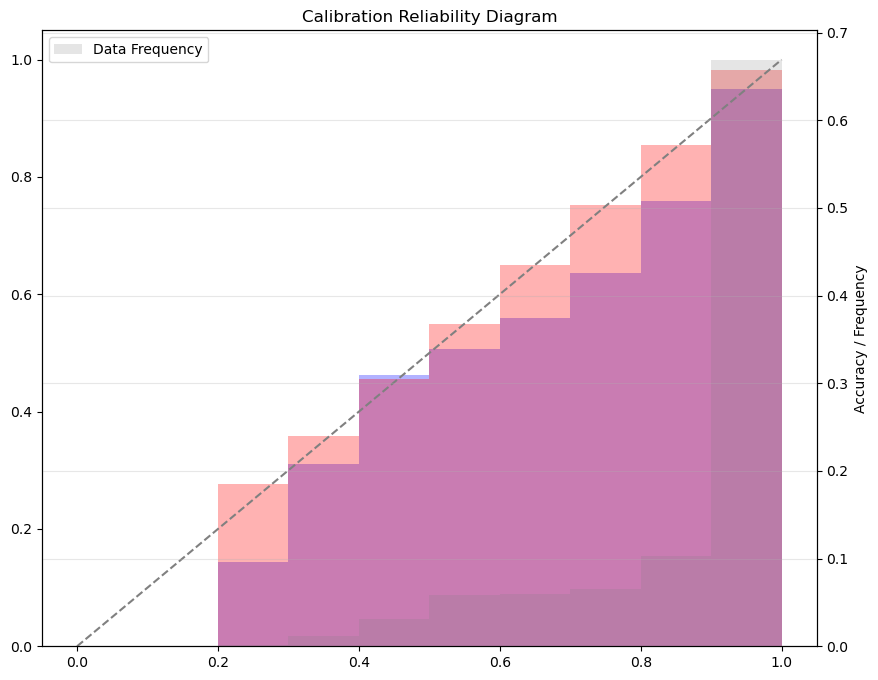

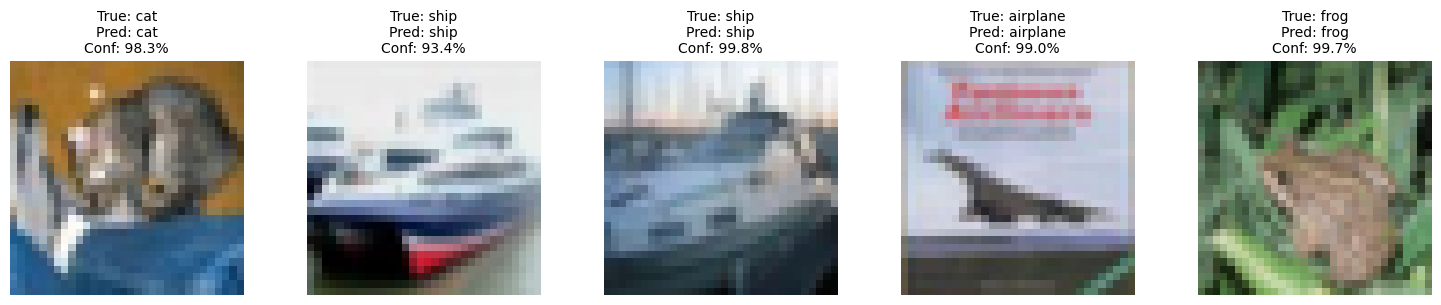

2025-03-22 14:41:56,732 [INFO] - Script completed successfully


In [ ]:
"""
Optimized ResNet50 Teacher Model Training Script
for Ensemble Distillation on CIFAR-10 Dataset (32x32 resolution)

Target Hardware: RTX 3060 Laptop (6GB VRAM) + Ryzen 7 6800H (8 cores/16 threads)
Optimizations:
- Automatic Mixed Precision (AMP) with updated PyTorch APIs
- Conservative batch size with gradient accumulation
- Specific RTX 3060 Laptop memory optimizations
"""

import os
import sys
import random
import time
import json
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Updated imports for AMP
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import gc  # For explicit garbage collection

# Define base paths
BASE_PATH = "C:\\Users\\Gading\\Downloads\\Research"
DATASET_PATH = os.path.join(BASE_PATH, "Dataset")
RESULTS_PATH = os.path.join(BASE_PATH, "Results")
MODELS_PATH = os.path.join(BASE_PATH, "Models")
SCRIPTS_PATH = os.path.join(BASE_PATH, "Scripts")

# Create model-specific paths
MODEL_NAME = "ResNet50"

# Create path for the specific model
MODEL_RESULTS_PATH = os.path.join(RESULTS_PATH, MODEL_NAME)
MODEL_CHECKPOINT_PATH = os.path.join(MODELS_PATH, MODEL_NAME, "checkpoints")
MODEL_EXPORT_PATH = os.path.join(MODELS_PATH, MODEL_NAME, "exports")

# Create necessary directories
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(MODEL_RESULTS_PATH, exist_ok=True)
os.makedirs(MODEL_CHECKPOINT_PATH, exist_ok=True)
os.makedirs(MODEL_EXPORT_PATH, exist_ok=True)
os.makedirs(SCRIPTS_PATH, exist_ok=True)

# Setup logging
log_file = os.path.join(MODEL_RESULTS_PATH, "resnet50_teacher_training.log")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
    logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    logger.info(f"CUDA Version: {torch.version.cuda}")
    # Enable cuDNN benchmark for optimal performance
    torch.backends.cudnn.benchmark = True
    logger.info("cuDNN benchmark mode enabled")

# Set seeds for reproducibility
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False  # Slightly faster with False
    logger.info(f"Random seed set to {seed}")

# Hyperparameters and configuration
class Config:
    def __init__(self):
        # General settings
        self.seed = 42
        self.model_name = "resnet50_teacher"
        self.dataset = "CIFAR-10"
        
        # Hardware-specific optimizations - FIXED VALUES for RTX 3060 Laptop (6GB)
        self.use_amp = True  # Automatic Mixed Precision
        self.memory_efficient_attention = False  # Not applicable to ResNet50
        self.prefetch_factor = 2  # DataLoader prefetch factor
        self.pin_memory = True  # Pin memory for faster CPU->GPU transfers
        self.persistent_workers = True  # Keep workers alive between epochs
        
        # RTX 3060 Laptop specific fixes
        self.batch_size = 128  # Higher batch size possible with ResNet50
        self.gradient_accumulation_steps = 1  # Reduced as ResNet50 is less memory-intensive 
        self.find_batch_size = False  # Disable auto-finding (using known values)
        self.gpu_memory_fraction = 0.8  # Can use more memory with ResNet50
        
        # Data settings
        self.input_size = 32  # Original CIFAR-10 image size
        self.vit_input_size = 224  # Required size for ViT model
        self.num_workers = 4  # Reduced from 8 to prevent memory contention
        self.val_split = 0.1  # 10% validation split
        self.dataset_path = DATASET_PATH
        
        # GPU cache clearing settings
        self.clear_cache_every_n_epochs = 2  # More frequent cache clearing
        
        # Model settings
        self.pretrained = True
        self.temperature = 1.0
        self.num_classes = 10  # CIFAR-10 has 10 classes
        self.use_zero_padding = True  # Pad images instead of distorting
        
        # Training settings
        self.epochs = 50
        self.lr = 3e-4
        self.weight_decay = 1e-4
        self.early_stop_patience = 10
        self.scheduler_T_max = 50
        
        # Loss weights
        self.ce_weight = 1.0      # Cross-entropy weight
        self.cal_weight = 0.1     # Maximum calibration weight
        
        # Curriculum scheduling settings
        self.use_curriculum = True  # Whether to use curriculum scheduling
        self.curriculum_ramp_epochs = 30  # Extended from 10 to 30 epochs for smoother calibration weight increase
        
        # Output settings
        self.checkpoint_dir = MODEL_CHECKPOINT_PATH
        self.results_dir = MODEL_RESULTS_PATH
        self.export_dir = MODEL_EXPORT_PATH
    
    def __str__(self):
        """String representation of the configuration"""
        return json.dumps(self.__dict__, indent=4)
    
    def save(self, path):
        """Save configuration to a JSON file"""
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=4)

    def get_calibration_weight(self, epoch):
        """
        Calculate the calibration weight for the current epoch based on curriculum scheduling
        """
        if not self.use_curriculum:
            return self.cal_weight
        
        # Linear ramp-up of calibration weight
        if epoch < self.curriculum_ramp_epochs:
            return self.cal_weight * (epoch + 1) / self.curriculum_ramp_epochs
        else:
            return self.cal_weight


# Memory utilities
def print_gpu_memory_stats():
    """Print GPU memory usage statistics"""
    if torch.cuda.is_available():
        current_mem = torch.cuda.memory_allocated() / 1024**2
        max_mem = torch.cuda.max_memory_allocated() / 1024**2
        reserved_mem = torch.cuda.memory_reserved() / 1024**2
        logger.info(f"GPU Memory: Current={current_mem:.2f}MB, Peak={max_mem:.2f}MB, Reserved={reserved_mem:.2f}MB")


def clear_gpu_cache():
    """Clear GPU cache to free up memory"""
    if torch.cuda.is_available():
        before_mem = torch.cuda.memory_allocated() / 1024**2
        torch.cuda.empty_cache()
        gc.collect()  # Explicit garbage collection
        after_mem = torch.cuda.memory_allocated() / 1024**2
        logger.info(f"GPU cache cleared: {before_mem:.2f}MB → {after_mem:.2f}MB (freed {before_mem-after_mem:.2f}MB)")


# Calibration Metrics
class CalibrationMetrics:
    @staticmethod
    def compute_ece(probs, targets, n_bins=15):
        """Compute Expected Calibration Error (ECE)"""
        # Get the confidence (max probability) and predictions
        confidences, predictions = torch.max(probs, dim=1)
        accuracies = (predictions == targets).float()
        
        # Sort by confidence
        sorted_indices = torch.argsort(confidences)
        sorted_confidences = confidences[sorted_indices]
        sorted_accuracies = accuracies[sorted_indices]
        
        # Create bins
        bin_size = 1.0 / n_bins
        bins = torch.linspace(0, 1.0, n_bins+1)
        ece = 0.0
        
        for i in range(n_bins):
            # Determine bin boundaries
            bin_start = bins[i]
            bin_end = bins[i+1]
            
            # Find samples in bin
            in_bin = (sorted_confidences >= bin_start) & (sorted_confidences < bin_end)
            bin_count = in_bin.sum()
            
            if bin_count > 0:
                bin_conf = sorted_confidences[in_bin].mean()
                bin_acc = sorted_accuracies[in_bin].mean()
                # Add weighted absolute difference to ECE
                ece += (bin_count / len(confidences)) * torch.abs(bin_acc - bin_conf)
        
        return ece
    
    @staticmethod
    def calibration_loss(logits, targets):
        """Compute a loss term that encourages better calibration"""
        probs = F.softmax(logits, dim=1)
        ece = CalibrationMetrics.compute_ece(probs, targets)
        return ece


# Dataset Preparation
def get_dataloaders(config):
    """Prepare CIFAR-10 dataset and dataloaders"""
    # For ViT models, we need to use ImageNet normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    if config.use_zero_padding:
        # Calculate padding required to bring 32x32 to 224x224
        pad_size = (config.vit_input_size - config.input_size) // 2
        logger.info(f"Using zero padding with pad_size={pad_size} pixels on each side")
        
        # Transform for training with zero padding and data augmentation
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
            transforms.Pad(pad_size, fill=0),
        ])
        
        # Transform for validation/test (zero padding, no augmentation)
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
            transforms.Pad(pad_size, fill=0),
        ])
    else:
        # Use resize approach
        logger.info(f"Using resize from {config.input_size}x{config.input_size} to "
                    f"{config.vit_input_size}x{config.vit_input_size}")
        
        # Transform for training with resize and data augmentation
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(config.vit_input_size, antialias=True),
            transforms.ToTensor(),
            normalize,
        ])
        
        # Transform for validation/test (resize, no augmentation)
        test_transform = transforms.Compose([
            transforms.Resize(config.vit_input_size, antialias=True),
            transforms.ToTensor(),
            normalize,
        ])
    
    # Set CIFAR-10 dataset path
    cifar10_path = os.path.join(config.dataset_path, "CIFAR-10")
    
    # Load CIFAR-10 dataset
    full_train_dataset = torchvision.datasets.CIFAR10(
        root=cifar10_path, train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=cifar10_path, train=False, download=True, transform=test_transform
    )
    
    # Split training set into train and validation
    val_size = int(len(full_train_dataset) * config.val_split)
    train_size = len(full_train_dataset) - val_size
    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(config.seed)
    )
    
    # Create a custom dataset for validation to apply the test transform
    val_dataset_with_transform = torch.utils.data.Subset(
        torchvision.datasets.CIFAR10(
            root=cifar10_path, train=True, download=False, transform=test_transform
        ),
        val_dataset.indices
    )
    
    # Create data loaders with optimized settings for RTX 3060
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        num_workers=config.num_workers, 
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    val_loader = DataLoader(
        val_dataset_with_transform, 
        batch_size=config.batch_size,
        shuffle=False, 
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config.batch_size,
        shuffle=False, 
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        persistent_workers=config.persistent_workers if config.num_workers > 0 else False,
        prefetch_factor=config.prefetch_factor if config.num_workers > 0 else None
    )
    
    logger.info(f"Training samples: {len(train_dataset)}")
    logger.info(f"Validation samples: {len(val_dataset)}")
    logger.info(f"Test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader


# Model Definition
def create_resnet50_model(config):
    """Create and initialize a ResNet50 model for CIFAR-10"""
    if config.pretrained:
        # Load pretrained ResNet50 model
        logger.info("Loading pretrained ResNet50 model...")
        weights = ResNet50_Weights.IMAGENET1K_V1
        model = resnet50(weights=weights)
    else:
        model = resnet50()
    
    # Replace the classification head for CIFAR-10
    num_classes = config.num_classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    logger.info(f"Model created: ResNet50 adapted for CIFAR-10 with {num_classes} classes")
    return model


# Training, Validation and Testing Functions
def train_epoch(model, train_loader, criterion, optimizer, scaler, device, config, epoch):
    """Train the model for one epoch with mixed precision and gradient accumulation"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Get calibration weight for current epoch based on curriculum scheduling
    current_cal_weight = config.get_calibration_weight(epoch)
    
    # Initialize counters for gradient accumulation
    steps_since_update = 0
    
    pbar = tqdm(train_loader, desc=f"Training (cal_weight={current_cal_weight:.4f})")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        try:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            # Zero the parameter gradients if not using gradient accumulation
            # or if it's time to update
            if config.gradient_accumulation_steps <= 1 or steps_since_update == 0:
                optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            
            # Forward pass with mixed precision
            with autocast(device_type='cuda', enabled=config.use_amp):
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                ce_loss = criterion(outputs, targets)
                
                # Add calibration loss with current weight from curriculum scheduling
                if current_cal_weight > 0:
                    cal_loss = CalibrationMetrics.calibration_loss(outputs, targets)
                    loss = config.ce_weight * ce_loss + current_cal_weight * cal_loss
                else:
                    loss = ce_loss
                
                # Scale loss if using gradient accumulation
                if config.gradient_accumulation_steps > 1:
                    loss = loss / config.gradient_accumulation_steps
            
            # Backward pass with mixed precision
            scaler.scale(loss).backward()
            
            # Update weights if not using gradient accumulation or if it's time
            steps_since_update += 1
            if config.gradient_accumulation_steps <= 1 or steps_since_update == config.gradient_accumulation_steps:
                # Unscale gradients before applying optimizer
                scaler.unscale_(optimizer)
                
                # Apply gradient clipping after unscaling but before stepping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
                steps_since_update = 0
            
            # Update statistics
            # If using gradient accumulation, we need to scale the loss back up for accurate reporting
            running_loss += loss.item() * (config.gradient_accumulation_steps if config.gradient_accumulation_steps > 1 else 1)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
                
        except Exception as e:
            logger.error(f"Error in training batch {batch_idx}: {str(e)}")
            # Try to free up memory
            clear_gpu_cache()
            # If problem persists, skip this batch and continue
            continue
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy


def validate(model, val_loader, criterion, device, config):
    """Validate the model with mixed precision"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validating"):
            try:
                inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                
                # Forward pass with mixed precision
                with autocast(device_type='cuda', enabled=config.use_amp):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                # Update statistics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                # Store for metrics calculation
                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                all_probs.append(F.softmax(outputs, dim=1).cpu())
            
            except Exception as e:
                logger.error(f"Error in validation: {str(e)}")
                clear_gpu_cache()
                continue
    
    # Calculate metrics
    all_probs = torch.cat(all_probs, dim=0)
    all_targets_tensor = torch.tensor(all_targets)
    
    avg_loss = running_loss / len(val_loader)
    accuracy = 100. * correct / total
    f1 = f1_score(all_targets, all_predictions, average='macro')
    ece = CalibrationMetrics.compute_ece(all_probs, all_targets_tensor).item()
    
    # Calculate additional metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'ece': ece
    }
    
    return metrics


def test(model, test_loader, device, config):
    """Test the model on the test set with mixed precision"""
    return validate(model, test_loader, nn.CrossEntropyLoss(), device, config)


# Main Training Loop
def train_model(config):
    """Main training function optimized for RTX 3060 Laptop GPU"""
    set_seed(config.seed)
    
    # Get dataloaders
    train_loader, val_loader, test_loader = get_dataloaders(config)
    
    # Create model
    model = create_resnet50_model(config)
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=config.scheduler_T_max)
    
    # Initialize AMP gradient scaler
    scaler = GradScaler(device='cuda') if config.use_amp else None
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'val_ece': [],
        'cal_weights': [],  # Track calibration weights over epochs
        'best_epoch': 0
    }
    
    # Early stopping setup
    best_val_loss = float('inf')
    early_stop_counter = 0
    
    # Get current time for model naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"{config.model_name}_{timestamp}"
    
    # Save full configuration before training
    config_path = os.path.join(config.results_dir, f"{model_name}_config.json")
    config.save(config_path)
    logger.info(f"Configuration saved to {config_path}")
    
    # Log effective batch size information
    effective_batch_size = config.batch_size * config.gradient_accumulation_steps
    logger.info(f"Batch size: {config.batch_size} with gradient accumulation steps: {config.gradient_accumulation_steps}")
    logger.info(f"Effective batch size: {effective_batch_size}")
    
    # Measure initial GPU memory usage
    print_gpu_memory_stats()
    
    # Training loop
    logger.info("Starting training...")
    try:
        for epoch in range(config.epochs):
            epoch_start_time = time.time()
            logger.info(f"Epoch {epoch+1}/{config.epochs}")
            
            # Clear GPU cache at the beginning of each epoch to ensure clean state
            clear_gpu_cache()
            
            # Get current calibration weight for logging
            current_cal_weight = config.get_calibration_weight(epoch)
            history['cal_weights'].append(current_cal_weight)
            
            # Train
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device, config, epoch)
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            # Clear cache before validation to ensure maximum available memory
            clear_gpu_cache()
            
            # Validate
            val_metrics = validate(model, val_loader, criterion, device, config)
            val_loss = val_metrics['loss']
            val_acc = val_metrics['accuracy']
            val_f1 = val_metrics['f1_score']
            val_ece = val_metrics['ece']
            
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)
            history['val_ece'].append(val_ece)
            
            # Update learning rate scheduler
            scheduler.step()
            
            # Calculate epoch time
            epoch_time = time.time() - epoch_start_time
            
            # Log metrics
            logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            logger.info(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, Val ECE: {val_ece:.4f}")
            logger.info(f"Epoch time: {epoch_time:.2f}s")
            
            # Save checkpoint after clearing cache
            clear_gpu_cache()
            
            try:
                # Save model checkpoint
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                    'val_f1': val_f1,
                    'val_ece': val_ece,
                    'config': config.__dict__
                }
                
                # Save latest model
                latest_path = os.path.join(config.checkpoint_dir, f"{model_name}_latest.pth")
                torch.save(checkpoint, latest_path)
                
                # Check if this is the best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    early_stop_counter = 0
                    history['best_epoch'] = epoch + 1
                    
                    # Save best model
                    best_path = os.path.join(config.checkpoint_dir, f"{model_name}_best.pth")
                    torch.save(checkpoint, best_path)
                    logger.info(f"Best model saved with Val Loss: {val_loss:.4f}")
                else:
                    early_stop_counter += 1
            
            except Exception as e:
                logger.error(f"Error saving checkpoint: {str(e)}")
            
            # Print memory stats at end of epoch
            print_gpu_memory_stats()
            
            # Early stopping
            if early_stop_counter >= config.early_stop_patience:
                logger.info(f"Early stopping after {epoch+1} epochs")
                break
        
        # Final evaluation on test set
        logger.info("Loading best model for final evaluation...")
        best_path = os.path.join(config.checkpoint_dir, f"{model_name}_best.pth")
        checkpoint = torch.load(best_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Clear cache before final testing
        clear_gpu_cache()
        
        # Test
        test_metrics = test(model, test_loader, device, config)
        logger.info(f"Test Metrics: {test_metrics}")
        
        # Save training history and config
        history_path = os.path.join(config.results_dir, f"{model_name}_history.json")
        with open(history_path, 'w') as f:
            json.dump(history, f, indent=4)
        logger.info(f"Training history saved to {history_path}")

        # Final memory stats
        print_gpu_memory_stats()
        
        logger.info("Training completed!")
        return model, history
        
    except Exception as e:
        logger.error(f"An error occurred during training: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        
        # Try to save a partial history for debugging
        try:
            partial_history_path = os.path.join(config.results_dir, f"{model_name}_partial_history.json")
            with open(partial_history_path, 'w') as f:
                json.dump(history, f, indent=4)
            logger.info(f"Partial training history saved to {partial_history_path}")
        except:
            logger.error("Could not save partial history")
        
        # Clear cache in case of error
        clear_gpu_cache()
        raise


def export_model_outputs(model, loader, device, config, num_batches=1):
    """Export model outputs for a few batches with mixed precision"""
    model.eval()
    exports = {
        'logits': [],
        'soft_probs': [],
        'targets': [],
        'temperature': config.temperature
    }
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            if i >= num_batches:
                break
            
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            # Forward pass with mixed precision
            with autocast(device_type='cuda', enabled=config.use_amp):
                logits = model(inputs)
            
            # Apply temperature scaling to soften the probabilities
            soft_probs = F.softmax(logits / config.temperature, dim=1)
            
            # Store outputs
            exports['logits'].append(logits.cpu().numpy())
            exports['soft_probs'].append(soft_probs.cpu().numpy())
            exports['targets'].append(targets.cpu().numpy())
    
    # Convert to numpy arrays
    for key in ['logits', 'soft_probs', 'targets']:
        if exports[key]:  # Check if there's any data
            exports[key] = np.vstack(exports[key]) if key != 'targets' else np.concatenate(exports[key])
    
    return exports


# Plot training history
def plot_history(history, save_path=None):
    """Plot training history"""
    plt.figure(figsize=(15, 12))
    
    # Plot training & validation loss
    plt.subplot(3, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.axvline(x=history['best_epoch']-1, color='r', linestyle='--', label='Best Model')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(3, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.axvline(x=history['best_epoch']-1, color='r', linestyle='--', label='Best Model')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot validation F1 score
    plt.subplot(3, 2, 3)
    plt.plot(history['val_f1'], label='Validation')
    plt.axvline(x=history['best_epoch']-1, color='r', linestyle='--', label='Best Model')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    # Plot validation ECE
    plt.subplot(3, 2, 4)
    plt.plot(history['val_ece'], label='Validation')
    plt.axvline(x=history['best_epoch']-1, color='r', linestyle='--', label='Best Model')
    plt.title('Expected Calibration Error')
    plt.xlabel('Epoch')
    plt.ylabel('ECE')
    plt.legend()
    
    # Plot calibration weights over epochs
    plt.subplot(3, 2, 5)
    plt.plot(history['cal_weights'], label='Cal. Weight')
    plt.axvline(x=history['best_epoch']-1, color='r', linestyle='--', label='Best Model')
    plt.title('Calibration Weights (Curriculum)')
    plt.xlabel('Epoch')
    plt.ylabel('Weight')
    plt.legend()
    
    # Add additional space for the title
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Add an overall title
    plt.suptitle(f"Training History - ResNet50 Teacher Model for CIFAR-10", fontsize=16)
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Plot saved to {save_path}")
    
    plt.show()


def plot_calibration_curve(model, test_loader, device, config, save_path=None):
    """Plot calibration curve showing reliability diagram (predicted confidence vs actual accuracy)"""
    model.eval()
    
    all_targets = []
    all_confidences = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Computing calibration data"):
            try:
                inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                
                # Forward pass with mixed precision
                with autocast(device_type='cuda', enabled=config.use_amp):
                    outputs = model(inputs)
                probs = F.softmax(outputs, dim=1)
                
                # Store confidence (max probability) and targets
                confidences, predictions = torch.max(probs, dim=1)
                all_targets.extend((predictions == targets).cpu().numpy())
                all_confidences.extend(confidences.cpu().numpy())
            except Exception as e:
                logger.error(f"Error in calibration calculation: {str(e)}")
                continue
    
    # Convert to numpy arrays
    all_targets = np.array(all_targets, dtype=np.bool_)
    all_confidences = np.array(all_confidences)
    
    # Create bins for the reliability diagram
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    
    # Initialize arrays for bin statistics
    bin_accuracies = np.zeros(n_bins)
    bin_confidences = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    # Compute statistics for each bin
    for i in range(n_bins):
        bin_mask = (all_confidences >= bin_edges[i]) & (all_confidences < bin_edges[i+1])
        bin_counts[i] = np.sum(bin_mask)
        if bin_counts[i] > 0:
            bin_accuracies[i] = np.mean(all_targets[bin_mask])
            bin_confidences[i] = np.mean(all_confidences[bin_mask])
    
    # Plot reliability diagram
    plt.figure(figsize=(10, 8))
    
    # Plot perfect calibration line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    
    # Plot actual calibration
    bin_sizes_norm = bin_counts / np.sum(bin_counts)
    plt.bar(bin_centers, bin_accuracies, width=1/n_bins, alpha=0.3, label='Accuracy in Bin', color='blue')
    plt.bar(bin_centers, bin_confidences, width=1/n_bins, alpha=0.3, label='Confidence in Bin', color='red')
    
    # Plot confidence histogram
    plt.twinx()
    plt.bar(bin_centers, bin_sizes_norm, width=1/n_bins, alpha=0.2, label='Data Frequency', color='gray')
    
    plt.title('Calibration Reliability Diagram')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy / Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Calibration curve saved to {save_path}")
    
    plt.show()


# Helper function to visualize a few examples
def visualize_examples(model, dataloader, device, config, num_examples=5):
    """Visualize a few examples from the dataset and model predictions"""
    # Get a batch of data
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        # Forward pass with mixed precision
        with autocast(device_type='cuda', enabled=config.use_amp):
            images_device = images[:num_examples].to(device, non_blocking=True)
            outputs = model(images_device)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Convert back to CPU for visualization
    images = images[:num_examples].cpu()
    labels = labels[:num_examples].cpu()
    predicted = predicted.cpu()
    probs = probs.cpu()
    
    # Get the class names for CIFAR-10
    classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Denormalize images for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Create a function to denormalize and prepare for plotting
    def denormalize(img):
        # First convert to numpy and transpose dimensions
        img = img.numpy().transpose((1, 2, 0))
        
        # Apply denormalization
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # If using padding, extract the center 32x32 region
        if img.shape[0] == 224:  # Check if we're using the 224x224 size
            pad = (img.shape[0] - 32) // 2
            img = img[pad:pad+32, pad:pad+32, :]
        
        return img
    
    # Plot the examples
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        ax = axes[i]
        img = denormalize(images[i])
        ax.imshow(img)
        
        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        confidence = probs[i, predicted[i]].item() * 100
        
        title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%"
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    try:
        # Initialize configuration
        config = Config()
        
        # Check CPU and GPU information
        logger.info(f"CPU: {os.cpu_count()} cores available")
        if torch.cuda.is_available():
            gpu_name = torch.cuda.get_device_name(0)
            gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
            logger.info(f"GPU: {gpu_name} with {gpu_mem:.2f}GB memory")
            
            # Check if this is the target RTX 3060
            if "3060" in gpu_name.lower():
                logger.info("RTX 3060 detected - using optimized settings")
                # Keep the predefined settings from Config() - already optimized for RTX 3060
            else:
                logger.info(f"Non-target GPU detected ({gpu_name}) - adjusting settings")
                # Adjust settings for unknown GPU
                config.batch_size = 32  # More conservative
        else:
            logger.warning("No GPU detected - using CPU settings (training will be slow)")
            config.batch_size = 8
            config.use_amp = False
            config.memory_efficient_attention = False
        
        # Log system information
        logger.info(f"Python version: {sys.version}")
        logger.info(f"PyTorch version: {torch.__version__}")
        logger.info(f"Torchvision version: {torchvision.__version__}")
        logger.info(f"Configuration: {config}")
        
        # Create a reference script with metadata
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        script_destination = os.path.join(SCRIPTS_PATH, f"resnet50_teacher_{timestamp}.py")
        
        try:
            # Check if running in a notebook or interactive environment
            if 'get_ipython' in globals():
                # We're in a notebook, save metadata
                with open(script_destination, 'w') as f:
                    f.write(f"# ResNet50 Teacher Training Script (Optimized for RTX 3060 Laptop)\n")
                    f.write(f"# Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                    f.write(f"# Python: {sys.version}\n")
                    f.write(f"# PyTorch: {torch.__version__}\n")
                    f.write(f"# Torchvision: {torchvision.__version__}\n\n")
                    f.write(f"# Configuration:\n")
                    f.write(json.dumps(config.__dict__, indent=4))
            else:
                # We're in a normal Python script
                with open(__file__, 'r') as src_file, open(script_destination, 'w') as dst_file:
                    dst_file.write(src_file.read())
                    
            logger.info(f"Script saved to {script_destination}")
        except Exception as e:
            logger.warning(f"Could not save script: {e}")
        
        # Set seed for reproducibility
        set_seed(config.seed)
        
        # Clear GPU cache before starting to ensure clean state
        clear_gpu_cache()
        
        # Train model
        model, history = train_model(config)
        
        # Plot and save training history
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plot_history(history, save_path=os.path.join(config.results_dir, f"{config.model_name}_{timestamp}_training_plot.png"))
        
        # Clear cache before evaluation
        clear_gpu_cache()
        
        # Plot calibration curve
        train_loader, val_loader, test_loader = get_dataloaders(config)
        plot_calibration_curve(model, test_loader, device, config,
                              save_path=os.path.join(config.results_dir, f"{config.model_name}_{timestamp}_calibration_curve.png"))
        
        # Visualize some examples
        visualize_examples(model, test_loader, device, config)
        
        logger.info("Script completed successfully")
        
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        
        # Clean up GPU memory in case of error
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
            logger.info("GPU memory cleared after error")